# Plotting Gad2 responses to running

### Packages

In [1]:
import numpy as np
import matplotlib as mlp
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter1d
from scipy.signal import resample
from scipy.stats import ks_2samp
import os
import json
import h5py
import pandas as pd
import seaborn as sns
import random

### Figure and plot settings

In [2]:
# set figure style
plt.style.use("seaborn-poster")

# set font, tick size and background color
plt.rcParams.update({'font.family':'arial'})
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.major.width'] = .5
plt.rcParams['figure.facecolor'] = 'w'

colors = np.array([[38, 55, 127], [197, 78, 83], [97, 97, 97]])/255 # Gad2LGN; Gad2PBG; CTR

### Set up paths and load data

In [3]:
# data paths, base_path directs to OpenData repository
base_path = r'E:\OneDrive - imec\ScienceAdvances\Final Submission\OpenData'
data_path = os.path.join(base_path, "Recreate Figures", "Submission_data", "Figure 6")
save_path = data_path

# load visual and running peak responses
visualVSlocomotion_LGN = pd.read_csv(os.path.join(data_path, "Gad2-LGN visual vs locomotion.csv"))
visualVSlocomotion_PBG = pd.read_csv(os.path.join(data_path, "Gad2-PBG visual vs locomotion.csv"))
visualVSlocomotion = visualVSlocomotion_LGN.copy()
visualVSlocomotion = pd.concat((visualVSlocomotion, visualVSlocomotion_PBG))


# load response correlations with running
with h5py.File(os.path.join(data_path, "RunningVsCalciumResponseCorrelation.h5"), 'r') as h5File:
    speed2cellCorrs_LGN = np.array(h5File.get('Gad2-LGN/speedCorrs'))
    speed2cellCorrs_LGN_shuffled = np.array(h5File.get('Gad2-LGN/speedCorrs_shuffled'))
    speed2cellCorrs_PBG = np.array(h5File.get('Gad2-PBG/speedCorrs'))
    speed2cellCorrs_PBG_shuffled = np.array(h5File.get('Gad2-PBG/speedCorrs_shuffled'))
    nShuffles = speed2cellCorrs_LGN_shuffled.shape[0]
    
    paths_LGN = np.array(h5File.get('Gad2-LGN/paths'), dtype=str)
    paths_PBG = np.array(h5File.get('Gad2-PBG/paths'), dtype=str)
    nCells_LGN = np.array(h5File.get('Gad2-LGN/n_cells'))
    nCells_PBG = np.array(h5File.get('Gad2-PBG/n_cells'))

# load running triggered responses
with h5py.File(os.path.join(data_path, "RunningTriggeredCalciumResponses.h5"), 'r') as h5File:
    runningTriggeredResponses_LGN = np.array(h5File.get('Gad2-LGN/running triggered medians'))
    runningTriggeredResponses_PBG = np.array(h5File.get('Gad2-PBG/running triggered medians'))
    medianSpeedTraces_LGN = np.array(h5File.get('Gad2-LGN/median speed traces'))
    medianSpeedTraces_PBG = np.array(h5File.get('Gad2-PBG/median speed traces'))


## Plot figure panels

### Panel B

LGN [ 789 1292 1883] PBG [185 270 326]


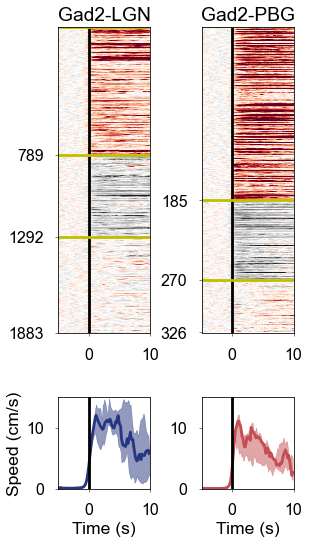

In [4]:
# parameters for running-triggered responses
speed_scaling_factor = 70. # measured in cm/s Misc/checkBallSpeed.ipynb
runningThres = .05*speed_scaling_factor
time_still_s = 5.
sampling_rate_Hz = 7.5
frames_still = int(time_still_s*sampling_rate_Hz)
tbins = np.arange(-time_still_s, 2*time_still_s, 1/sampling_rate_Hz)
tbins = (tbins[:-1]+tbins[1:])/2
groups = [-1, 0, 1] # up modulated, down modulated, non modulated

n_LGN_experiments, n_LGN_cells = 34, 1883
n_PBG_experiments, n_PBG_cells = 15, 326

groups_LGN, groups_PBG = np.ones((n_LGN_cells, )), np.ones((n_PBG_cells, ))
running_modulation_LGN = np.median(runningTriggeredResponses_LGN[:, frames_still:2*(frames_still)], axis=1)-np.median(runningTriggeredResponses_LGN[:, :frames_still], axis=1)
running_modulation_PBG = np.median(runningTriggeredResponses_PBG[:, frames_still:2*(frames_still)], axis=1)-np.median(runningTriggeredResponses_PBG[:, :frames_still], axis=1)
groups_LGN[running_modulation_LGN > (1*np.std(runningTriggeredResponses_LGN[:, :frames_still], axis=1))] = -1
groups_LGN[running_modulation_LGN < -(1*np.std(runningTriggeredResponses_LGN[:, :frames_still], axis=1))] = 0
groups_PBG[running_modulation_PBG > (1*np.std(runningTriggeredResponses_PBG[:, :frames_still], axis=1))] = -1
groups_PBG[running_modulation_PBG < -(1*np.std(runningTriggeredResponses_PBG[:, :frames_still], axis=1))] = 0
nCells_group_LGN = [np.sum(groups_LGN==ii) for ii in [-1, 0, 1]]
nCells_group_PBG = [np.sum(groups_PBG==ii) for ii in [-1, 0, 1]]
print('LGN', np.cumsum(nCells_group_LGN), 'PBG', np.cumsum(nCells_group_PBG))
ROIorder_LGN = np.argsort(groups_LGN)
ROIorder_PBG = np.argsort(groups_PBG)

runningTriggeredResponses_LGN_norm = np.zeros(runningTriggeredResponses_LGN.shape)
runningTriggeredResponses_PBG_norm = np.zeros(runningTriggeredResponses_PBG.shape)
for ROI in range(n_LGN_cells):
    runningTriggeredResponses_LGN_norm[ROI, :] = (runningTriggeredResponses_LGN[ROI, :]-np.nanmean(runningTriggeredResponses_LGN[ROI, :frames_still]))/np.nanstd(runningTriggeredResponses_LGN[ROI, :frames_still])
for ROI in range(n_PBG_cells):
    runningTriggeredResponses_PBG_norm[ROI, :] = (runningTriggeredResponses_PBG[ROI, :]-np.nanmean(runningTriggeredResponses_PBG[ROI, :frames_still]))/np.nanstd(runningTriggeredResponses_PBG[ROI, :frames_still])
        
fig = plt.figure(figsize=(4.4, 8))
gs = GridSpec(4, 2, fig)

colormap = 'RdGy_r'
vmin, vmax = -10, 10

fig.add_subplot(gs[:3, 0])
plt.imshow(runningTriggeredResponses_LGN_norm[ROIorder_LGN, :], aspect=50/n_LGN_cells, interpolation='none',
           extent=[-time_still_s, 2*time_still_s, n_LGN_cells, 1], origin='upper', cmap=colormap, vmin=vmin, vmax=vmax)
plt.plot(np.zeros((2, )), [.5, n_LGN_cells+.5], 'k')
plt.title('Gad2-LGN')
plt.ylim([n_LGN_cells+.5, .5])
#plt.colorbar(location = 'bottom')
for groupID in range(len(groups)):
    plt.plot([-time_still_s, 2*time_still_s], np.ones((2,))*np.sum(nCells_group_LGN[:groupID]), 'y')
plt.yticks(np.cumsum(nCells_group_LGN))

fig.add_subplot(gs[:3, 1])
plt.imshow(runningTriggeredResponses_PBG_norm[ROIorder_PBG, :], aspect=50/n_PBG_cells, interpolation='none',
           extent=[-time_still_s, 2*time_still_s, n_PBG_cells, 1], origin='upper', cmap=colormap, vmin=vmin, vmax=vmax)
plt.plot(np.zeros((2, )), [.5, n_PBG_cells+.5], 'k')
plt.title('Gad2-PBG')
plt.ylim([n_PBG_cells+.5, .5])
#plt.colorbar(location = 'bottom')
for groupID in range(len(groups)):
    plt.plot([-time_still_s, 2*time_still_s], np.ones((2,))*np.sum(nCells_group_PBG[:groupID]), 'y')
plt.yticks(np.cumsum(nCells_group_PBG))

fig.add_subplot(gs[3, 0])
plt.plot(tbins, np.nanmedian(medianSpeedTraces_LGN, axis=0), color=colors[0, :])
plt.fill_between(tbins, np.nanpercentile(medianSpeedTraces_LGN, 25, axis=0),
                    np.nanpercentile(medianSpeedTraces_LGN, 75, axis=0), color=colors[0, :], alpha=.5)
plt.ylabel('Speed (cm/s)')
plt.plot(np.zeros((2, )), [0, 15], 'k')
plt.xlabel('Time (s)')
plt.xlim([-5, 10])
plt.ylim([0, 15])

fig.add_subplot(gs[3, 1])
plt.plot(tbins, np.nanmedian(medianSpeedTraces_PBG, axis=0), color=colors[1, :])
plt.fill_between(tbins, np.nanpercentile(medianSpeedTraces_PBG, 25, axis=0),
                    np.nanpercentile(medianSpeedTraces_PBG, 75, axis=0), color=colors[1, :], alpha=.5)
plt.plot(np.zeros((2, )), [0, 15], 'k')
plt.xlabel('Time (s)')
plt.xlim([-5, 10])
plt.ylim([0, 15])

plt.tight_layout()
plt.savefig(os.path.join(save_path, 'Figure6-B.tif'), dpi = 300, bbox_inches = 'tight')

### Panel C

c:\Users\Norma\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Norma\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


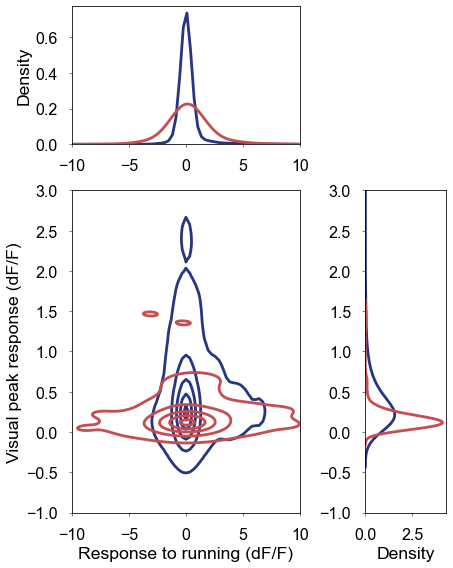

In [5]:
fig = plt.figure(figsize=(6.4, 8))
gs = GridSpec(3, 3, fig)
fig.add_subplot(gs[1:, :2])
smooth_factor = .5
smooth_method = 'scott'
plot_levels = [.05, .25, .5, .75, .95]
plot_range = [-10, 10, -1, 3]

sns.kdeplot(visualVSlocomotion_LGN['Modulation by locomotion'], 
            visualVSlocomotion_LGN['Median visual peak response'], 
            color=colors[0, :], label='Gad2-LGd', levels=plot_levels, bw_method=smooth_method)
sns.kdeplot(visualVSlocomotion_PBG['Modulation by locomotion'], 
            visualVSlocomotion_PBG['Median visual peak response'], 
            color=colors[1, :], label='Gad2-PBG', levels=plot_levels, bw_method=smooth_method)
plt.axis(plot_range)
plt.xlabel('Response to running (dF/F)')
plt.ylabel('Visual peak response (dF/F)')

# plot densities of running repsonses
fig.add_subplot(gs[0, :2])
sns.kdeplot(visualVSlocomotion_LGN['Modulation by locomotion'], color=colors[0, :], label='Gad2-LGd', bw_method=smooth_method)
sns.kdeplot(visualVSlocomotion_PBG['Modulation by locomotion'], color=colors[1, :], label='Gad2-PBG', bw_method=smooth_method)
plt.xlabel('')
plt.xlim(plot_range[0:2])

# plot densities of visual peak responses
fig.add_subplot(gs[1:, 2])
sns.kdeplot(y=visualVSlocomotion_LGN['Median visual peak response'], color=colors[0, :], label='Gad2-LGd', bw_method=smooth_method)
sns.kdeplot(y=visualVSlocomotion_PBG['Median visual peak response'], color=colors[1, :], label='Gad2-PBG', bw_method=smooth_method)
plt.ylabel('')
plt.ylim(plot_range[2:])

plt.tight_layout()

plt.savefig(os.path.join(save_path, 'Figure6-C.tif'), dpi = 300, bbox_inches = 'tight')

### Panel D

LGN 789 503 PBG 185 85
up KstestResult(statistic=0.24915561949782483, pvalue=1.122232762273967e-08)
down KstestResult(statistic=0.40088878493743424, pvalue=5.10453901370056e-11)
non KstestResult(statistic=0.10505801305293691, pvalue=0.5848576905620384)


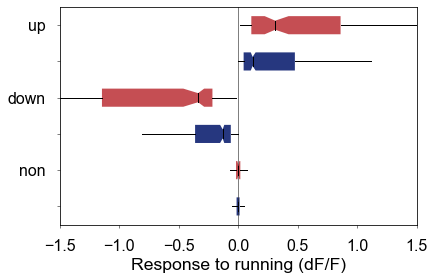

In [6]:
# grouping of runing responses
groups_LGN, groups_PBG = np.ones((n_LGN_cells, )), np.ones((n_PBG_cells, ))
running_modulation_LGN = np.median(runningTriggeredResponses_LGN[:, frames_still:2*(frames_still)], axis=1)-np.median(runningTriggeredResponses_LGN[:, :frames_still], axis=1)
running_modulation_PBG = np.median(runningTriggeredResponses_PBG[:, frames_still:2*(frames_still)], axis=1)-np.median(runningTriggeredResponses_PBG[:, :frames_still], axis=1)
groups_LGN[running_modulation_LGN > (1*np.std(runningTriggeredResponses_LGN[:, :frames_still], axis=1))] = -1
groups_LGN[running_modulation_LGN < -(1*np.std(runningTriggeredResponses_LGN[:, :frames_still], axis=1))] = 0
groups_PBG[running_modulation_PBG > (1*np.std(runningTriggeredResponses_PBG[:, :frames_still], axis=1))] = -1
groups_PBG[running_modulation_PBG < -(1*np.std(runningTriggeredResponses_PBG[:, :frames_still], axis=1))] = 0
print('LGN', np.sum(groups_LGN==-1), np.sum(groups_LGN==0), 'PBG', np.sum(groups_PBG==-1), np.sum(groups_PBG==0))
grouped_responses_LGN = [running_modulation_LGN[groups_LGN==ii]/100 for ii in [-1, 0, 1]]
grouped_responses_PBG = [running_modulation_PBG[groups_PBG==ii]/100 for ii in [-1, 0, 1]]

# Kolmogorov Smirnov test
group_names = ['up', 'down', 'non']
for group in range(3):
    print(group_names[group], ks_2samp(grouped_responses_LGN[group], grouped_responses_PBG[group]))

# plot up-, down- and non-modulated peak responses
plt.figure(figsize=(6.4, 4))
plt.boxplot(grouped_responses_LGN, positions=[4, 2, 0], vert=False, showcaps=False, showfliers=False, notch=True, bootstrap=10000, patch_artist=True, boxprops={'facecolor':colors[0, :], 'edgecolor':'none'}, medianprops=dict(color='k'))
plt.boxplot(grouped_responses_PBG, positions=[5, 3, 1], vert=False, showcaps=False, showfliers=False, notch=True, bootstrap=10000, patch_artist=True, boxprops={'facecolor':colors[1, :], 'edgecolor':'none'}, medianprops=dict(color='k'))
plt.xlim([-1.5, 1.5])
plt.plot([0, 0], [-.5, 5.5], 'k', lw=.5)
plt.yticks(np.arange(6), ['', 'non', '', 'down', '', 'up'])
plt.xlabel('Response to running (dF/F)')

saveFileName = os.path.join(save_path, 'Figure6-D.tif')
plt.savefig(saveFileName, dpi = 300, bbox_inches = 'tight')

### Panel E

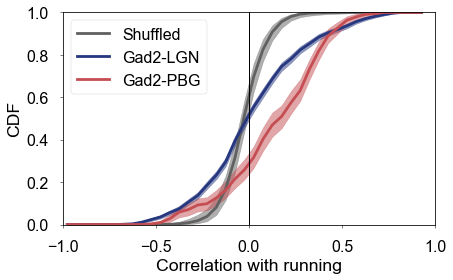

In [7]:
plt.figure(figsize=(6.4, 4))
corrBin = 0.05
corrBins = np.arange(-1, 1, corrBin)
for plotID, targetArea in enumerate(['LGN', 'PBG']):
    if targetArea == 'LGN':
        speed2cellCorrs = speed2cellCorrs_LGN
        speed2cellCorrs_shuffled = speed2cellCorrs_LGN_shuffled
        nROIs = speed2cellCorrs_LGN.size
        color = colors[0, :]
    else:
        speed2cellCorrs = speed2cellCorrs_PBG
        speed2cellCorrs_shuffled = speed2cellCorrs_PBG_shuffled
        nROIs = speed2cellCorrs_PBG.size
        color = colors[1, :]
    
    shuffledHists = np.zeros((nShuffles, len(corrBins)-1))
    bootstrap_hists = np.zeros((nShuffles, len(corrBins)-1))
    for shuffleID in range(nShuffles):
        shuffledHists[shuffleID, :] = (np.histogram(speed2cellCorrs_shuffled[shuffleID, :], bins=corrBins)[0]/nROIs)
        bootstrap_hists[shuffleID, :] = (np.histogram(speed2cellCorrs[[random.randint(0, nROIs-1) for x in range(nROIs)]], bins=corrBins)[0]/nROIs)
    shuffledHists_cum = np.cumsum(shuffledHists, axis=1)
    bootstrap_hists_cum = np.cumsum(bootstrap_hists, axis=1)
    shuffledHists /= corrBin
    bootstrap_hists /= corrBin

    # cdf of running correlations
    if targetArea == 'LGN':
        plt.plot(corrBins[:-1]+corrBin/2, np.median(shuffledHists_cum, axis=0), color=colors[2, :], label='Shuffled')
        plt.fill_between(corrBins[:-1]+corrBin/2, np.percentile(shuffledHists_cum, 2.5, axis=0), 
                        np.percentile(shuffledHists_cum, 97.5, axis=0), color=colors[2, :], alpha=.5)
    plt.plot(corrBins[:-1]+corrBin/2, np.median(bootstrap_hists_cum, axis=0), color=colors[plotID, :], label='Gad2-%s' %(targetArea), alpha=1)
    plt.fill_between(corrBins[:-1]+corrBin/2, np.percentile(bootstrap_hists_cum, 2.5, axis=0), 
                     np.percentile(bootstrap_hists_cum, 97.5, axis=0), color=colors[plotID, :], alpha=.5)
plt.ylabel('CDF')
plt.plot([0, 0], [0, 1], 'k', lw=1)
plt.axis([-1, 1, 0, 1])
plt.xlabel('Correlation with running')
plt.legend()

plt.tight_layout()

saveFileName = os.path.join(save_path, 'Figure6-E.tif')
plt.savefig(saveFileName, dpi = 300, bbox_inches = 'tight')